#Recommendation of Products based on Similar Products

##1.Data Preprocessing and feature extraction for Recommendation of Products based on Similar Products

In [52]:
%%bash
pip install stemming

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [53]:
import string
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from stemming.porter2 import stem
import networkx 
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.pylab as plt
from IPython.display import Image
from community import community_louvain
from collections import Counter
from itertools import chain
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
import plotly.io as pio
pio.renderers.default = 'browser'
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [54]:
"""from google.colab import drive
drive.mount('/content/drive')"""

"from google.colab import drive\ndrive.mount('/content/drive')"

In [55]:
!gdown --id 1-MyYRp_5NnmU1JWvl1jV6Dhe3o2HAjdc

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-MyYRp_5NnmU1JWvl1jV6Dhe3o2HAjdc
To: /content/amazon-meta.txt
100% 978M/978M [00:04<00:00, 224MB/s]


In [56]:
!gdown --id 1XwBFgm_vdUTCe6LUkqSSNJanVOpx7OGP

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1XwBFgm_vdUTCe6LUkqSSNJanVOpx7OGP
To: /content/amazon0601.txt
100% 47.9M/47.9M [00:00<00:00, 233MB/s]


#### Open the file to read Amazon Product Metadata

In [57]:
df = open ('/content/amazon-meta.txt', 'r', encoding='utf-8', errors= 'ignore')

#### Initialize a nested product dictionary that will hold cleaned up amazon product data. 

In [58]:
amazonProducts= {}

### Read the data from the Amazon meta information file and fill the AmazonProducts nested dictionary with features of products and extracted features of users reviews

In [59]:
(Id, ASIN, Title, Categories, Group, Copurchased, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff,no_sim) = ("", "", "", "", "", "", 0, 0, 0.0, 0, 0.0,0)

for line in df:
    line = line.strip()
    if(line.startswith("Id")): # a product block started
        Id = line[3:].strip()
    elif(line.startswith("ASIN")):
        ASIN = line[5:].strip()
    elif(line.startswith("title")):
        Title = line[6:].strip()
        Title = ' '.join(Title.split())
        continue
    elif(line.startswith("group")):
        Group = line[6:].strip()
    elif(line.startswith("salesrank")):
        SalesRank = line[10:].strip()
    elif(line.startswith("similar")):
        ls = line.split()
        no_sim = ls[1:2]
        Copurchased = ' '.join([c for c in ls[2:]])
    elif(line.startswith("categories")):
        ls = line.split()
        Categories = ' '.join((df.readline()).lower() for i in range(int(ls[1].strip())))
        Categories = re.compile('[%s]' % re.escape(string.digits+string.punctuation)).sub(' ',Categories)
        Categories = ' '.join(set(Categories.split())-set(stopwords.words("english")))
        Categories = ' '.join(stem(word) for word in Categories.split())
    elif(line.startswith("reviews")):
        ls = line.split()
        TotalReviews = ls[2].strip()
        AvgRating = ls[7].strip() # a product block ended
    elif (line==""): # write out fields to amazonProducts dictionary
        try:
            MetaData = {}
            if (ASIN != ""):
                amazonProducts[ASIN] = MetaData
            MetaData['Id'] = Id
            MetaData['Title'] = Title
            MetaData['Categories'] = ' '.join(set(Categories.split()))
            MetaData['Group'] = Group
            MetaData['Copurchased'] = Copurchased
            MetaData['SalesRank'] = int(SalesRank)
            MetaData['TotalReviews'] = int(TotalReviews)
            MetaData['AvgRating'] = float(AvgRating)
            MetaData['NoSim'] = no_sim
        except NameError:
            continue
        (Id, ASIN, Title, Categories, Group, Copurchased, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff,no_sim) = ("", "", "", "", "", "", 0, 0, 0.0, 0, 0.0,0)
df.close

<function TextIOWrapper.close>

In [60]:
for asin, metadata in amazonProducts.items():
    amazonProducts[asin]['Copurchased']= ' '.join([cp for cp in metadata['Copurchased'].split() if cp in amazonProducts.keys()])

##### Converting dictionary to dataframe

In [61]:
df = pd.DataFrame.from_dict(amazonProducts)
df = df.T

##### Helper Functions

In [62]:
def getclean(l):
    if(type(l)==int):
      return l
    else:
      p = int(l[0]) 
    return p  

In [63]:
df

,Id,Title,Categories,Group,Copurchased,SalesRank,TotalReviews,AvgRating,NoSim
0771044445,0,,,,,0,0,0.0,0
0827229534,1,Patterns of Preaching: A Sermon Sampler,subject book sermon religion christian clergi ...,Book,0804215715 156101074X 0687023955 0687074231 08...,396585,2,5.0,[5]
0738700797,2,Candlemas: Feast of Flames,wicca subject book earth religion base witchcr...,Book,0738700827 1567184960 1567182836 0738700525 07...,168596,12,4.5,[5]
0486287785,3,World War II Allied Fighter Planes Trading Cards,subject garden book craft home hobbi general,Book,,1270652,1,5.0,[0]
0842328327,4,Life Application Bible Commentary: 1 and 2 Tim...,commentari new christian discipleship translat...,Book,0842328130 0842330313 0842328610 0842328572,631289,1,4.0,[5]
...,...,...,...,...,...,...,...,...,...
B000059TOC,548547,The Drifter,timothi genr delaney featur b mysteri titl ama...,DVD,630366704X,0,1,5.0,[5]
B00006JBIX,548548,The House Of Morecock,dvd specialti art genr titl anim independ inte...,DVD,B00004WZQN,0,8,3.0,[5]
0879736836,548549,Catholic Bioethics and the Gift of Human Life,general scienc catholic histori subject book r...,Book,1580510469 0896229939,0,1,4.0,[5]
B00008DDST,548550,"1, 2, 3 Soleils: Taha, Khaled, Faudel",dvd general music amazon today outlet genr dea...,DVD,,0,3,5.0,[5]


In [64]:
df['NoSim'] = df['NoSim'].apply(lambda x: getclean(x))
df['ASIN'] = df.index
df = df.set_index('Id')

In [65]:
df.to_csv('/content/Similar_Products.csv')

##2. Recommendation System of Similar Products using extracted previously

### Reading transaction data from co-purchases edgelist dataset

In [66]:
"""from google.colab import drive
drive.mount('/content/drive')"""

"from google.colab import drive\ndrive.mount('/content/drive')"

In [67]:
Graphtype = nx.DiGraph()
filepath = '/content/amazon0601.txt' 
G = nx.read_edgelist(
    filepath,
    comments='#',
    create_using=Graphtype,
    nodetype=int
)

In [68]:
df = pd.read_csv('/content/Similar_Products.csv') 

In [69]:
df = df.dropna(axis=0, subset=['Title'])

In [70]:
df.head()

,Id,Title,Categories,Group,Copurchased,SalesRank,TotalReviews,AvgRating,NoSim,ASIN
1,1,Patterns of Preaching: A Sermon Sampler,subject book sermon religion christian clergi ...,Book,0804215715 156101074X 0687023955 0687074231 08...,396585,2,5.0,5,0827229534
2,2,Candlemas: Feast of Flames,wicca subject book earth religion base witchcr...,Book,0738700827 1567184960 1567182836 0738700525 07...,168596,12,4.5,5,0738700797
3,3,World War II Allied Fighter Planes Trading Cards,subject garden book craft home hobbi general,Book,NaN,1270652,1,5.0,0,0486287785
4,4,Life Application Bible Commentary: 1 and 2 Tim...,commentari new christian discipleship translat...,Book,0842328130 0842330313 0842328610 0842328572,631289,1,4.0,5,0842328327
5,5,Prayers That Avail Much for Business: Executive,live subject book christian religion devot bus...,Book,157794349X 0892749504 1577941829 0892749563,455160,0,0.0,5,1577943082


In [71]:
df.isnull().sum()

Id                   0
Title                0
Categories       22903
Group                0
Copurchased     181117
SalesRank            0
TotalReviews         0
AvgRating            0
NoSim                0
ASIN                 0
dtype: int64

In [72]:
df['NoSim'].value_counts()

5    337457
0    163591
1     11071
2     10808
3     10275
4      9482
Name: NoSim, dtype: int64

In [73]:
nodeattrdf = df[['Title','ASIN' ,'Categories', 'Group', 'Copurchased', 'SalesRank','TotalReviews', 'AvgRating', 'NoSim']].copy()

In [74]:
nx.set_node_attributes(G, nodeattrdf.to_dict('index'))

In [75]:
G.nodes[2]

{'ASIN': '0738700797',
 'AvgRating': 4.5,
 'Categories': 'wicca subject book earth religion base witchcraft spiritu',
 'Copurchased': '0738700827 1567184960 1567182836 0738700525 0738700940',
 'Group': 'Book',
 'NoSim': 5,
 'SalesRank': 168596,
 'Title': 'Candlemas: Feast of Flames',
 'TotalReviews': 12}

####Removing nodes with no links

In [76]:
remove = [nodes for nodes in dict(G.nodes()) if len(G.nodes[nodes]) == 0] 

In [77]:
G.remove_nodes_from(remove)

In [78]:
remove[:10]

[0, 355, 1033, 3957, 1053, 1961, 298, 4962, 12465, 1152]

In [79]:
G.number_of_nodes()

398814

####Creating an array of permissible nodes

In [80]:
n = list(G.nodes) 
n =  np.array(n)
n = np.unique(n)

In [81]:
#taking input that is allowed
tempinput = int(input())
if(tempinput in n):
  pro_id = tempinput
  print("Selected product is", pro_id)
else:
  print("Empty node has been removed from the graph!")

5
Selected product is 5


In [82]:
pro_dict = G.nodes[pro_id]

In [83]:
pro_dict #details of the product selected by the user

{'ASIN': '1577943082',
 'AvgRating': 0.0,
 'Categories': 'live subject book christian religion devot busi prayerbook spiritu worship',
 'Copurchased': '157794349X 0892749504 1577941829 0892749563',
 'Group': 'Book',
 'NoSim': 5,
 'SalesRank': 455160,
 'Title': 'Prayers That Avail Much for Business: Executive',
 'TotalReviews': 0}

####Creating a list of the ASINs of the products that are similar to the product selected

In [84]:
arr

nan

In [85]:
arr = pro_dict['Copurchased']
arr = arr.split(' ')
print(len(arr))
arr = np.array(arr)
arr

4


array(['157794349X', '0892749504', '1577941829', '0892749563'],
      dtype='<U10')

#####Helper Function to get similar product recommendations

In [86]:
def getsimilar(arr):
  indarr = []
  counter = 0
  for i in arr:
    indx = df.index[df['ASIN'] == i][0]
    if(indx in n):
      print(G.nodes[indx])
      indarr.append(indx)
    else:
      counter = counter+1
  return counter, indarr

In [87]:
counter, indarr = getsimilar(arr)
print(indarr)
print(counter,"nodes have been removed from the graph")

{'Title': 'Prayers That Avail Much for the Workplace: The Business Handbook of Scriptural Prayer', 'ASIN': '157794349X', 'Categories': 'life subject prayer book home offic religion busi devot workplac com amazon store invest christian spiritu prayerbook worship', 'Group': 'Book', 'Copurchased': '0892749504 1577941829 1577943082 0892749563', 'SalesRank': 221617, 'TotalReviews': 0, 'AvgRating': 0.0, 'NoSim': 5}
{'Title': 'Prayers That Avail Much: Three Bestselling Works Complete In One Volume, 25th Anniversary Commemorative', 'ASIN': '0892749504', 'Categories': 'subject book inspir religion christian devot worship prayerbook spiritu', 'Group': 'Book', 'Copurchased': '1577941829 0892749563 157794349X', 'SalesRank': 16962, 'TotalReviews': 16, 'AvgRating': 4.5, 'NoSim': 5}
[305321, 173362]
2 nodes have been removed from the graph


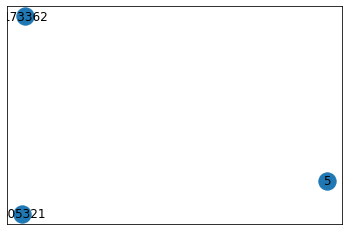

In [88]:
disparr = np.append(indarr, pro_id)
H = G.subgraph(disparr)
nx.draw_networkx(H, with_labels = True,edge_color = 'r')

In [89]:
#nx.write_gpickle(G, '/content/drive/MyDrive/GNN_datasets/G.gpickle')